In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import GBTRegressor, DecisionTreeRegressor
from xgboost.spark import SparkXGBRegressor
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.sql.functions import hour, dayofweek, log1p
from pyspark.sql.functions import round, when, col
from pyspark.sql.functions import log1p
import psutil
import threading
import builtins
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType
import numpy as np
import time

/usr/local/lib/python3.8/dist-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [2]:
spark = SparkSession.builder.appName("NewYorkCityTaxiTripDuration") \
    .master("local[*]") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.memory.fraction", "0.9") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

25/04/18 18:02:57 WARN Utils: Your hostname, dgour-HP-Laptop-15-db1xxx resolves to a loopback address: 127.0.1.1; using 192.168.1.56 instead (on interface wlo1)
25/04/18 18:02:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/18 18:02:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
full_data = spark.read.csv("train.csv", header=True, inferSchema=True)

In [4]:
full_data = full_data.sample(fraction=0.1, seed=42)

In [5]:
# Indexers
vendor_indexer = StringIndexer(inputCol="vendor_id", outputCol="vendor_id_index", handleInvalid="keep")
store_flag_indexer = StringIndexer(inputCol="store_and_fwd_flag", outputCol="store_and_fwd_index", handleInvalid="keep")

# Δημιουργία χρονικών χαρακτηριστικών
full_data = full_data.withColumn("pickup_hour", hour(col("pickup_datetime")))
full_data = full_data.withColumn("pickup_weekday", dayofweek(col("pickup_datetime")))
full_data = full_data.withColumn("dropoff_hour", hour(col("dropoff_datetime")))
full_data = full_data.withColumn("dropoff_weekday", dayofweek(col("dropoff_datetime")))

full_feature_cols = [
    "vendor_id_index", "store_and_fwd_index",
    "passenger_count", "pickup_longitude", "pickup_latitude",
    "dropoff_longitude", "dropoff_latitude",
    "pickup_hour", "pickup_weekday",
    "dropoff_hour", "dropoff_weekday"
]

# VectorAssembler
assembler = VectorAssembler(inputCols=full_feature_cols, outputCol="features")

# Z-score κανονικοποίηση
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

pipeline = Pipeline(stages=[
    vendor_indexer,
    store_flag_indexer,
    assembler,
    scaler
])

# Fit και Transform
pipeline_model = pipeline.fit(full_data)
full_data = pipeline_model.transform(full_data)

# Τελική επιλογή στηλών
full_data = full_data.select("scaled_features", "trip_duration")
full_data = full_data.withColumn("trip_duration", log1p(col("trip_duration")))


In [6]:
# Ορισμός κλάσης για την παρακολούθηση των τιμών των υπολογιστικών πόρων(CPU, memory, Disk I/O)

class ResourceMonitorListener:
    def __init__(self):
        self.cpu_percentages = []
        self.mem_percentages = []
        self.disk_reads = []
        self.disk_writes = []
        self.monitoring = False

    def start_monitoring(self):
        self.monitoring = True
        self.cpu_percentages = []
        self.mem_percentages = []
        self.disk_reads = [psutil.disk_io_counters().read_bytes]
        self.disk_writes = [psutil.disk_io_counters().write_bytes]

# Δημιουργία thread: κάθε 1 δευτερόλεπτο ενημερώνει τις λίστες που περιέχουν τις τιμές των πόρων
        def monitor_loop():
            while self.monitoring:
                self.cpu_percentages.append(psutil.cpu_percent(interval=1))
                self.mem_percentages.append(psutil.virtual_memory().percent)
                disk_io = psutil.disk_io_counters()
                self.disk_reads.append(disk_io.read_bytes)
                self.disk_writes.append(disk_io.write_bytes)

        self.monitor_thread = threading.Thread(target=monitor_loop, daemon=True)
        self.monitor_thread.start()

# Διακοπή του thread 
    def stop_monitoring(self):
        self.monitoring = False
        self.monitor_thread.join()

        self.disk_reads = [x for x in self.disk_reads if isinstance(x, (int, float))]
        self.disk_writes = [x for x in self.disk_writes if isinstance(x, (int, float))]

        # Υπολογισμός των τελικών τιμών
        cpu_avg = sum(self.cpu_percentages) / len(self.cpu_percentages) if self.cpu_percentages else 0
        mem_avg = sum(self.mem_percentages) / len(self.mem_percentages) if self.mem_percentages else 0

        # Χρήση των ενσωματωμένων max/min της Python(και όχι του PySpark)
        disk_read_mb = ((builtins.max(self.disk_reads) - builtins.min(self.disk_reads)) / (1024 * 1024)) if self.disk_reads else 0
        disk_write_mb = ((builtins.max(self.disk_writes) - builtins.min(self.disk_writes)) / (1024 * 1024)) if self.disk_writes else 0

        # Επιστρέφει ένα λεξικό που περιέχει τις μετρήσεις
        return {
            "cpu_usage": cpu_avg,
            "mem_usage": mem_avg,
            "disk_read_mb": disk_read_mb,
            "disk_write_mb": disk_write_mb
        }

In [7]:
train_data, test_data = full_data.randomSplit([0.8, 0.2], seed=42)

In [14]:
# Εύρεση των κατάλληλων παραμέτρων για το μοντέλο Decision Tree Regressor

from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, when, round

# Evaluator
evaluator_rmse = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="r2")

# Ορισμός grid υπερπαραμέτρων
max_depths = [10, 20, 30]
min_instances = [10, 30, 50]

best_model = None
best_params = None
best_rmse = float("inf")  # για επιλογή βάσει RMSE

for depth in max_depths:
    for min_inst in min_instances:
        print(f"\nTraining with maxDepth={depth}, minInstancesPerNode={min_inst}")

        # Ορισμός μοντέλου
        dt = DecisionTreeRegressor(
            featuresCol='scaled_features',
            labelCol='trip_duration',
            maxDepth=depth,
            minInstancesPerNode=min_inst
        )

        model = dt.fit(train_data)
        predictions = model.transform(test_data)

        # Στρογγυλοποίηση και καθαρισμός αρνητικών
        predictions = predictions.withColumn(
            "prediction",
            when(col("prediction") < 0, 0).otherwise(round(col("prediction"), 0))
        )

        # Μετρικές
        rmse = evaluator_rmse.evaluate(predictions)
        r2 = evaluator_r2.evaluate(predictions)

        print(f"RMSE: {rmse:.4f} | R²: {r2:.4f}")

        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_params = {'maxDepth': depth, 'minInstancesPerNode': min_inst}

# ==== Τελική αξιολόγηση ====
print("\n==== Best Decision Tree Model ====")
print(f"Best Params: {best_params}")
print(f"Best RMSE: {best_rmse:.4f}")



Training with maxDepth=10, minInstancesPerNode=10


RMSE: 0.6791 | R²: 0.2777

Training with maxDepth=10, minInstancesPerNode=30


RMSE: 0.6733 | R²: 0.2899

Training with maxDepth=10, minInstancesPerNode=50


RMSE: 0.6737 | R²: 0.2890

Training with maxDepth=20, minInstancesPerNode=10


RMSE: 0.6085 | R²: 0.4200

Training with maxDepth=20, minInstancesPerNode=30


RMSE: 0.5998 | R²: 0.4364

Training with maxDepth=20, minInstancesPerNode=50


RMSE: 0.6022 | R²: 0.4319

Training with maxDepth=30, minInstancesPerNode=10


RMSE: 0.6060 | R²: 0.4248

Training with maxDepth=30, minInstancesPerNode=30


RMSE: 0.5991 | R²: 0.4378

Training with maxDepth=30, minInstancesPerNode=50


RMSE: 0.6024 | R²: 0.4316

==== Best Decision Tree Model ====
Best Params: {'maxDepth': 30, 'minInstancesPerNode': 30}
Best RMSE: 0.5991


Training with 10.0% of data

Training XGBoost Regressor...


2025-04-18 16:39:24,650 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 2 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'max_depth': 10, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
/usr/local/lib/python3.8/dist-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/xgboost/core.py:265: FutureWarning: Your system has an 


XGBoost Regressor (Data Size: 10.0%)
RMSE: 0.5766
MAE: 0.4190
R-Squared: 0.4793
Training Time: 10.24 sec - Inference Latency: 0.21 sec
*Training* CPU: 30.98% | Memory: 85.70%
*Training* Disk Read: 139.47 MB | Write: 9.95 MB
*Inference* CPU: 17.40% | Memory: 87.20%
*Inference* Disk Read: 0.31 MB | Write: 0.00 MB

Training GBT Regressor...



GBT Regressor (Data Size: 10.0%)
RMSE: 0.5691
MAE: 0.4175
R-Squared: 0.4926
Training Time: 83.58 sec - Inference Latency: 0.11 sec
*Training* CPU: 70.46% | Memory: 88.44%
*Training* Disk Read: 1318.55 MB | Write: 315.90 MB
*Inference* CPU: 8.80% | Memory: 81.50%
*Inference* Disk Read: 0.10 MB | Write: 0.00 MB

Training Decision Tree Regressor...


2025-04-18 16:41:41,907 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 2 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'max_depth': 10, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}



Decision Tree Regressor (Data Size: 10.0%)
RMSE: 0.6462
MAE: 0.4742
R-Squared: 0.3460
Training Time: 2.77 sec - Inference Latency: 0.07 sec
*Training* CPU: 61.07% | Memory: 81.60%
*Training* Disk Read: 2.63 MB | Write: 3.97 MB
*Inference* CPU: 5.90% | Memory: 81.60%
*Inference* Disk Read: 0.03 MB | Write: 0.00 MB
Training with 25.0% of data

Training XGBoost Regressor...


/usr/local/lib/python3.8/dist-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algo


XGBoost Regressor (Data Size: 25.0%)
RMSE: 0.5438
MAE: 0.4006
R-Squared: 0.5368
Training Time: 8.24 sec - Inference Latency: 0.12 sec
*Training* CPU: 23.27% | Memory: 83.87%
*Training* Disk Read: 12.68 MB | Write: 2.44 MB
*Inference* CPU: 2.90% | Memory: 84.50%
*Inference* Disk Read: 0.18 MB | Write: 3.49 MB

Training GBT Regressor...



GBT Regressor (Data Size: 25.0%)
RMSE: 0.5590
MAE: 0.4109
R-Squared: 0.5104
Training Time: 77.23 sec - Inference Latency: 0.10 sec
*Training* CPU: 64.91% | Memory: 88.43%
*Training* Disk Read: 39.00 MB | Write: 39.84 MB
*Inference* CPU: 2.50% | Memory: 81.00%
*Inference* Disk Read: 0.11 MB | Write: 0.00 MB

Training Decision Tree Regressor...


2025-04-18 16:43:48,973 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 2 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'max_depth': 10, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}



Decision Tree Regressor (Data Size: 25.0%)
RMSE: 0.6217
MAE: 0.4534
R-Squared: 0.3946
Training Time: 3.83 sec - Inference Latency: 0.07 sec
*Training* CPU: 63.12% | Memory: 81.03%
*Training* Disk Read: 0.09 MB | Write: 0.00 MB
*Inference* CPU: 2.50% | Memory: 81.20%
*Inference* Disk Read: 0.02 MB | Write: 2.14 MB
Training with 50.0% of data

Training XGBoost Regressor...


/usr/local/lib/python3.8/dist-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algo


XGBoost Regressor (Data Size: 50.0%)
RMSE: 0.5224
MAE: 0.3866
R-Squared: 0.5726
Training Time: 8.43 sec - Inference Latency: 0.12 sec
*Training* CPU: 20.64% | Memory: 83.30%
*Training* Disk Read: 1.31 MB | Write: 3.25 MB
*Inference* CPU: 3.80% | Memory: 84.00%
*Inference* Disk Read: 0.01 MB | Write: 0.00 MB

Training GBT Regressor...



GBT Regressor (Data Size: 50.0%)
RMSE: 0.5514
MAE: 0.4062
R-Squared: 0.5237
Training Time: 81.15 sec - Inference Latency: 0.10 sec
*Training* CPU: 65.75% | Memory: 87.89%
*Training* Disk Read: 0.59 MB | Write: 45.12 MB
*Inference* CPU: 2.10% | Memory: 81.40%
*Inference* Disk Read: 0.02 MB | Write: 0.00 MB

Training Decision Tree Regressor...


2025-04-18 16:45:59,110 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 2 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'max_depth': 10, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}



Decision Tree Regressor (Data Size: 50.0%)
RMSE: 0.6112
MAE: 0.4451
R-Squared: 0.4148
Training Time: 5.55 sec - Inference Latency: 0.06 sec
*Training* CPU: 62.07% | Memory: 81.28%
*Training* Disk Read: 0.42 MB | Write: 6.18 MB
*Inference* CPU: 2.50% | Memory: 81.30%
*Inference* Disk Read: 0.04 MB | Write: 0.00 MB
Training with 100% of data

Training XGBoost Regressor...


/usr/local/lib/python3.8/dist-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algo


XGBoost Regressor (Data Size: 100%)
RMSE: 0.5020
MAE: 0.3748
R-Squared: 0.6053
Training Time: 9.17 sec - Inference Latency: 0.08 sec
*Training* CPU: 21.04% | Memory: 83.61%
*Training* Disk Read: 0.31 MB | Write: 5.55 MB
*Inference* CPU: 1.60% | Memory: 84.30%
*Inference* Disk Read: 0.00 MB | Write: 0.00 MB


2025-04-18 16:46:24,410 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
/usr/local/lib/python3.8/dist-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You h

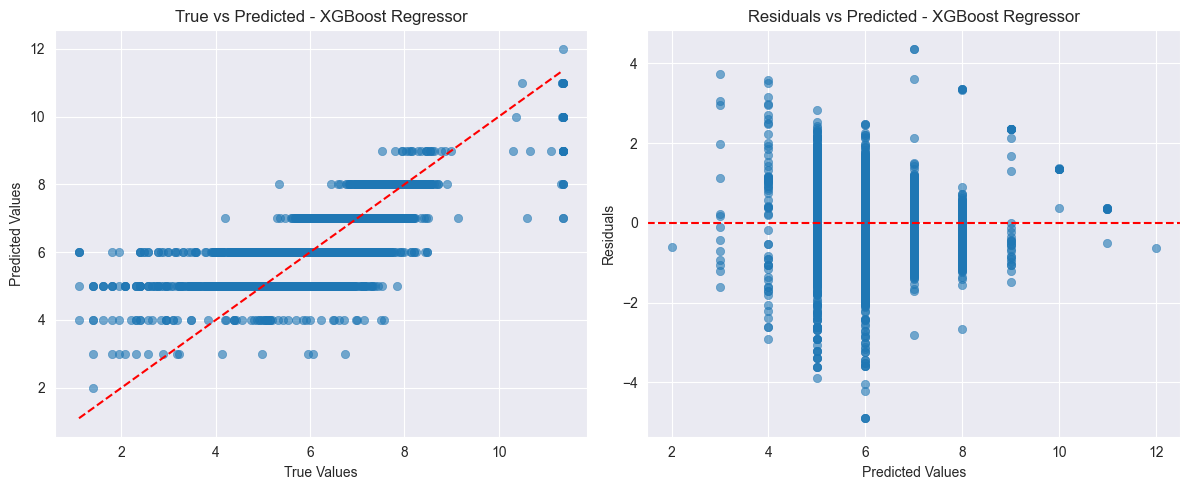


Training GBT Regressor...



GBT Regressor (Data Size: 100%)
RMSE: 0.5515
MAE: 0.4071
R-Squared: 0.5236
Training Time: 93.85 sec - Inference Latency: 0.11 sec
*Training* CPU: 67.88% | Memory: 90.09%
*Training* Disk Read: 219.31 MB | Write: 44.88 MB
*Inference* CPU: 2.80% | Memory: 78.90%
*Inference* Disk Read: 0.02 MB | Write: 0.00 MB


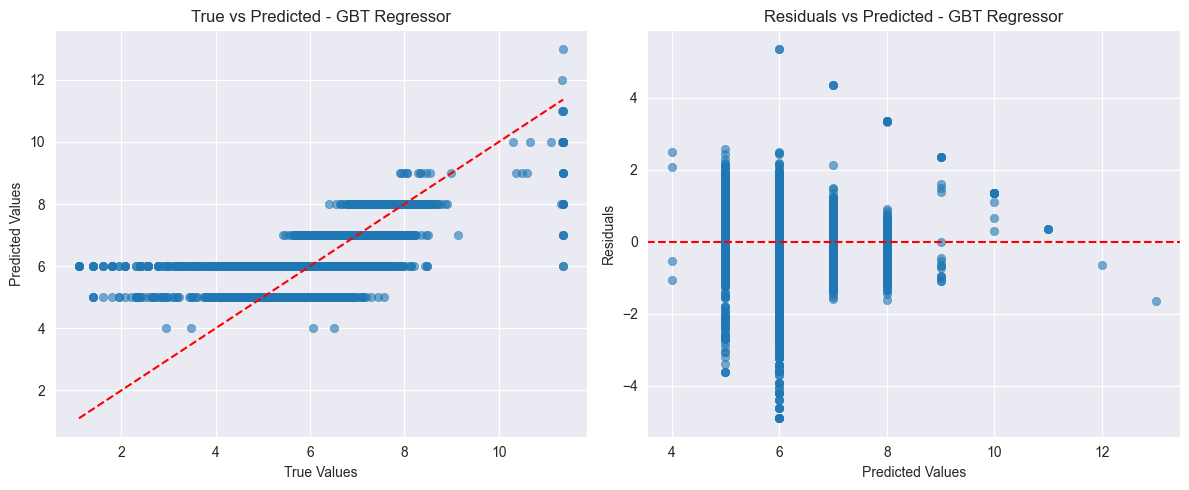


Training Decision Tree Regressor...



Decision Tree Regressor (Data Size: 100%)
RMSE: 0.5979
MAE: 0.4352
R-Squared: 0.4400
Training Time: 8.51 sec - Inference Latency: 0.03 sec
*Training* CPU: 69.21% | Memory: 80.14%
*Training* Disk Read: 0.13 MB | Write: 5.02 MB
*Inference* CPU: 18.30% | Memory: 80.20%
*Inference* Disk Read: 0.00 MB | Write: 0.00 MB


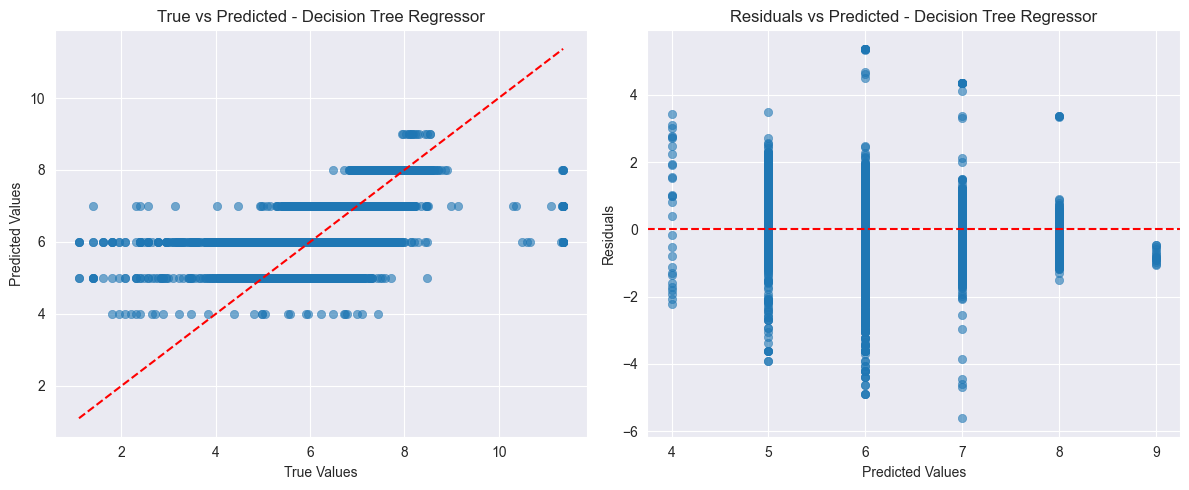

In [11]:
# Βελτίωση της απόδοσης του Spark:
# 1) Κατανομή των δεδομένων σε 20 partitions.
# 2) Αποθήκευση των δεδομένων στη μνήμη RAM.Αν ξαναχρειαστούμε τα δεδομένα δε θα διαβαστούν από το δίσκο.

import matplotlib.pyplot as plt
import seaborn as sns

train_data = train_data.repartition(20).cache()
train_count = train_data.count()

# Listener για παρακολούθηση υπολογιστικών πόρων
monitor = ResourceMonitorListener()

# Ποσοστά δεδομένων για testing scaling
sizes = [0.1, 0.25, 0.5, 1]

evaluator_rmse = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="r2")
evaluator_mae = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="mae")

for size in sizes:
    print(f"Training with {size * 100}% of data")

    if size == 1:
        train_subset = train_data
    else:
        train_subset = train_data.sample(fraction=size, seed=42)
        
        '''        
        "Random Forest Regressor": RandomForestRegressor(
            featuresCol="scaled_features",
            labelCol="trip_duration",
            numTrees=130,
            maxDepth=12,
            minInstancesPerNode=5,
            featureSubsetStrategy="sqrt",
        )
        '''

    # Ορισμός μοντέλων
    models = {
        "XGBoost Regressor": SparkXGBRegressor(
            features_col="scaled_features",
            label_col="trip_duration",
            num_workers=2,
            max_depth=10
        ),
        "GBT Regressor": GBTRegressor(
            featuresCol='scaled_features',
            labelCol='trip_duration',
            maxIter=100,
            maxDepth=5
        ),
        "Decision Tree Regressor": DecisionTreeRegressor(
            featuresCol='scaled_features',
            labelCol='trip_duration',
            maxDepth=30,
            minInstancesPerNode=30,
            maxBins=64
        )
    }

    for name, model in models.items():
        print(f"\nTraining {name}...")

        monitor.start_monitoring()
        start_train = time.time()
        trained_model = model.fit(train_subset)
        training_time = time.time() - start_train
        train_metrics = monitor.stop_monitoring()

        time.sleep(3)

        start_infer = time.time()
        monitor.start_monitoring()
        predictions = trained_model.transform(test_data)
        inference_latency = time.time() - start_infer
        infer_metrics = monitor.stop_monitoring()

        predictions = predictions.withColumn(
            "prediction",
            when(col("prediction") < 0, 0).otherwise(round(col("prediction"), 0))
        )

        # Μετρικές
        rmse = evaluator_rmse.evaluate(predictions)
        r2 = evaluator_r2.evaluate(predictions)
        mae = evaluator_mae.evaluate(predictions)

        # Εκτύπωση αποτελεσμάτων
        print(f"\n{name} (Data Size: {size * 100}%)")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"R-Squared: {r2:.4f}")
        print(f"Training Time: {training_time:.2f} sec - Inference Latency: {inference_latency:.2f} sec")
        print(f"*Training* CPU: {train_metrics['cpu_usage']:.2f}% | Memory: {train_metrics['mem_usage']:.2f}%")
        print(f"*Training* Disk Read: {train_metrics['disk_read_mb']:.2f} MB | Write: {train_metrics['disk_write_mb']:.2f} MB")
        print(f"*Inference* CPU: {infer_metrics['cpu_usage']:.2f}% | Memory: {infer_metrics['mem_usage']:.2f}%")
        print(f"*Inference* Disk Read: {infer_metrics['disk_read_mb']:.2f} MB | Write: {infer_metrics['disk_write_mb']:.2f} MB")

        # === Plots μόνο για το 100% των δεδομένων ===
        if size == 1:
            preds_pd = predictions.select("trip_duration", "prediction").dropna().toPandas()
            preds_pd["residuals"] = preds_pd["trip_duration"] - preds_pd["prediction"]

            plt.figure(figsize=(12, 5))

            # Scatter Plot: True vs Predicted
            plt.subplot(1, 2, 1)
            sns.scatterplot(x=preds_pd["trip_duration"], y=preds_pd["prediction"], alpha=0.6, edgecolor=None)
            plt.plot(
                [preds_pd["trip_duration"].min(), preds_pd["trip_duration"].max()],
                [preds_pd["trip_duration"].min(), preds_pd["trip_duration"].max()],
                color='red', linestyle='--'
            )
            plt.xlabel("True Values")
            plt.ylabel("Predicted Values")
            plt.title(f"True vs Predicted - {name}")

            # Residual Plot
            plt.subplot(1, 2, 2)
            sns.scatterplot(x=preds_pd["prediction"], y=preds_pd["residuals"], alpha=0.6, edgecolor=None)
            plt.axhline(0, color='red', linestyle='--')
            plt.xlabel("Predicted Values")
            plt.ylabel("Residuals")
            plt.title(f"Residuals vs Predicted - {name}")

            plt.tight_layout()
            plt.show()


In [14]:
# Βελτιστοποίηση με GridSearch CV

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

# UDF για μετατροπή Vector σε λίστα
vector_to_array_udf = udf(lambda v: v.toArray().tolist(), ArrayType(DoubleType()))

# Μετατροπή Spark σε pandas
train_pd = train_data.select(
    vector_to_array_udf("scaled_features").alias("features"), "trip_duration"
).dropna().toPandas()

test_pd = test_data.select(
    vector_to_array_udf("scaled_features").alias("features"), "trip_duration"
).dropna().toPandas()

X_train = np.vstack(train_pd["features"].values)
y_train = train_pd["trip_duration"].values
X_test = np.vstack(test_pd["features"].values)
y_test = test_pd["trip_duration"].values

# Ορισμός μοντέλου
knn = KNeighborsRegressor()

# Ορισμός grid υπερπαραμέτρων
param_grid = {
    'n_neighbors': [7, 9, 11, 13],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],  
    'leaf_size': [10, 20, 30]
}

# Επιλογή scorer: neg RMSE ή R²
scoring = 'neg_root_mean_squared_error'  # ή 'r2'

# GridSearchCV με 3-fold cross-validation
grid = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring=scoring,
    cv=3,
    verbose=2,
    n_jobs=-1
)

print("Training GridSearchCV for KNN...")
start_time = time.time()
grid.fit(X_train, y_train)
train_duration = time.time() - start_time

# Καλύτερο μοντέλο
best_knn = grid.best_estimator_
print("\nBest KNN Parameters:")
print(grid.best_params_)

# Προβλέψεις
y_pred = best_knn.predict(X_test)
y_pred = np.where(y_pred < 0, 0, np.round(y_pred))  # καθαρισμός

# Μετρικές
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

print(f"\nFinal Evaluation on Test Set:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")
print(f"Adjusted R²: {adj_r2:.4f}")
print(f"Training Time: {train_duration:.2f} sec")

Training GridSearchCV for KNN...
Fitting 3 folds for each of 48 candidates, totalling 144 fits

✅ Best KNN Parameters:
{'leaf_size': 10, 'n_neighbors': 11, 'p': 2, 'weights': 'distance'}

Final Evaluation on Test Set:
RMSE: 0.6244
MAE: 0.4587
R²: 0.3894
Adjusted R²: 0.3891
Training Time: 731.55 sec


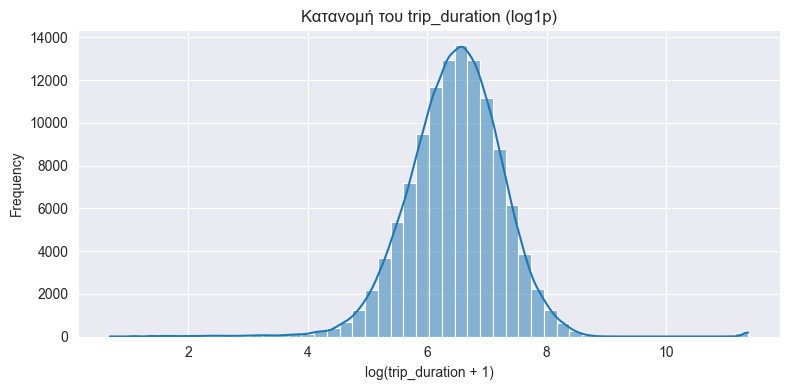

In [14]:
# Κατανομή του λογαρίθμου της εξαρτώμενης μεταβλητής

import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType

vector_to_array_udf = udf(lambda v: v.toArray().tolist(), ArrayType(DoubleType()))

train_pd = train_data.select(
    vector_to_array_udf("scaled_features").alias("features"),
    "trip_duration"
).dropna().toPandas()

plt.figure(figsize=(8, 4))
sns.histplot(train_pd['trip_duration'], bins=50, kde=True)
plt.title("Κατανομή του trip_duration (log1p)")
plt.xlabel("log(trip_duration + 1)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


KNN Training with 10.0% of data


Training K-Nearest Neighbors Regressor (KNN)...

KNN Results for 10.0% data:
RMSE: 0.6925
MAE: 0.5184
R-Squared: 0.2488
Training Time: 0.03 sec | Inference Latency: 2.09 sec
*Training* CPU: 63.40% | Memory: 87.30%
*Training* Disk Read: 0.00 MB | Write: 0.29 MB
*Inference* CPU: 68.23% | Memory: 87.37%
*Inference* Disk Read: 0.00 MB | Write: 0.00 MB

KNN Training with 25.0% of data


Training K-Nearest Neighbors Regressor (KNN)...

KNN Results for 25.0% data:
RMSE: 0.6647
MAE: 0.4920
R-Squared: 0.3078
Training Time: 0.08 sec | Inference Latency: 2.54 sec
*Training* CPU: 6.40% | Memory: 87.40%
*Training* Disk Read: 0.00 MB | Write: 0.00 MB
*Inference* CPU: 83.20% | Memory: 87.40%
*Inference* Disk Read: 0.00 MB | Write: 0.55 MB

KNN Training with 50.0% of data


Training K-Nearest Neighbors Regressor (KNN)...

KNN Results for 50.0% data:
RMSE: 0.6417
MAE: 0.4730
R-Squared: 0.3550
Training Time: 0.18 sec | Inference Latency: 3.24 sec
*Training* CPU: 5.80% | Memory: 87.60%
*Training* Disk Read: 0.00 MB | Write: 0.00 MB
*Inference* CPU: 78.52% | Memory: 87.60%
*Inference* Disk Read: 0.00 MB | Write: 0.00 MB

KNN Training with 100% of data


Training K-Nearest Neighbors Regressor (KNN)...

KNN Results for 100% data:
RMSE: 0.6244
MAE: 0.4587
R-Squared: 0.3894
Training Time: 0.51 sec | Inference Latency: 4.24 sec
*Training* CPU: 13.40% | Memory: 88.00%
*Training* Disk Read: 0.00 MB | Write: 0.00 MB
*Inference* CPU: 84.18% | Memory: 88.00%
*Inference* Disk Read: 0.04 MB | Write: 0.07 MB


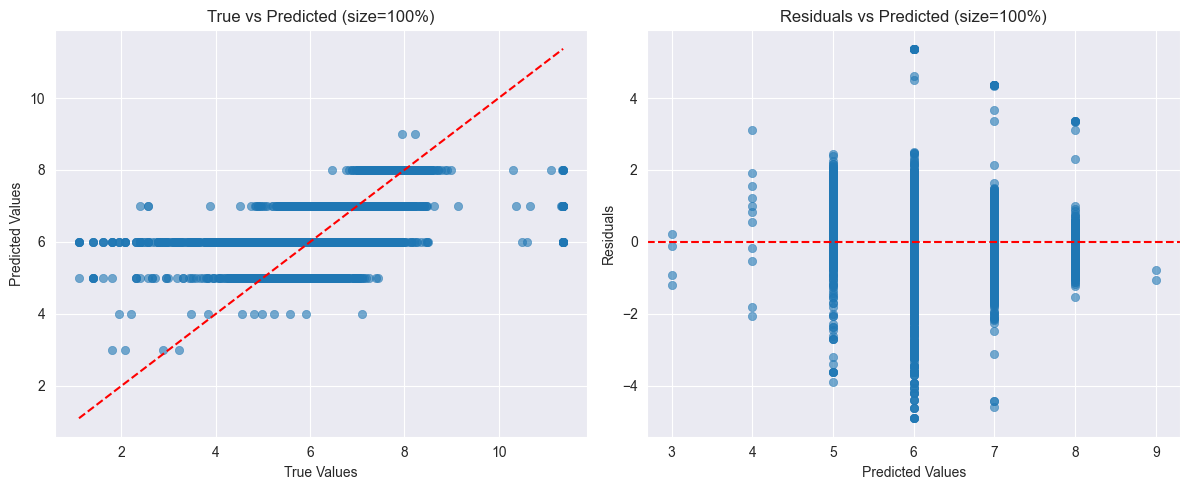

In [20]:
# Ξεχωριστό cell για το μοντέλο KNN, καθώς είναι διαφορετική η όλη διαδικασία για το συγκεκριμένο μοντέλο σε αντίθεση με τα προηγούμενα.

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

# UDF για μετατροπή Vector σε λίστα
vector_to_array_udf = udf(lambda v: v.toArray().tolist(), ArrayType(DoubleType()))

monitor = ResourceMonitorListener()

# Repartition και cache
train_data = train_data.repartition(20).cache()
train_count = train_data.count()

sizes = [0.1, 0.25, 0.5, 1]

for size in sizes:
    print(f"\nKNN Training with {size * 100}% of data")

    # Υποσύνολο δεδομένων
    train_subset = train_data if size == 1 else train_data.sample(fraction=size, seed=42)

    # Μετατροπή σε pandas
    train_pd = train_subset.select(
        vector_to_array_udf("scaled_features").alias("features"), "trip_duration"
    ).dropna().toPandas()

    test_pd = test_data.select(
        vector_to_array_udf("scaled_features").alias("features"), "trip_duration"
    ).dropna().toPandas()

    X_train = np.vstack(train_pd["features"].values)
    y_train = train_pd["trip_duration"].values
    X_test = np.vstack(test_pd["features"].values)
    y_test = test_pd["trip_duration"].values

    # Εκπαίδευση
    print("Training K-Nearest Neighbors Regressor (KNN)...")
    monitor.start_monitoring()
    start_train = time.time()

    knn_model = KNeighborsRegressor(
        n_neighbors=11,
        weights='distance',
        algorithm='auto',
        leaf_size=10,
        p=2,
        n_jobs=-1
    )
    knn_model.fit(X_train, y_train)

    training_time = time.time() - start_train
    train_metrics = monitor.stop_monitoring()

    # Inference
    time.sleep(3)
    monitor.start_monitoring()
    start_infer = time.time()

    y_pred = knn_model.predict(X_test)

    inference_latency = time.time() - start_infer
    infer_metrics = monitor.stop_monitoring()

    # Καθαρισμός αρνητικών προβλέψεων
    y_pred = np.where(y_pred < 0, 0, np.round(y_pred))

    # Μετρικές
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Εκτύπωση αποτελεσμάτων
    print(f"\nKNN Results for {size * 100}% data:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R-Squared: {r2:.4f}")
    print(f"Training Time: {training_time:.2f} sec | Inference Latency: {inference_latency:.2f} sec")
    print(f"*Training* CPU: {train_metrics['cpu_usage']:.2f}% | Memory: {train_metrics['mem_usage']:.2f}%")
    print(f"*Training* Disk Read: {train_metrics['disk_read_mb']:.2f} MB | Write: {train_metrics['disk_write_mb']:.2f} MB")
    print(f"*Inference* CPU: {infer_metrics['cpu_usage']:.2f}% | Memory: {infer_metrics['mem_usage']:.2f}%")
    print(f"*Inference* Disk Read: {infer_metrics['disk_read_mb']:.2f} MB | Write: {infer_metrics['disk_write_mb']:.2f} MB")

    # ========== Διαγράμματα ==========
    if size == 1:
        plt.figure(figsize=(12, 5))
    
        # Scatter Plot: True vs Predicted
        plt.subplot(1, 2, 1)
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, edgecolor=None)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        plt.title(f"True vs Predicted (size={int(size*100)}%)")
    
        # Residual Plot
        residuals = y_test - y_pred
        plt.subplot(1, 2, 2)
        sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, edgecolor=None)
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel("Predicted Values")
        plt.ylabel("Residuals")
        plt.title(f"Residuals vs Predicted (size={int(size*100)}%)")
    
        plt.tight_layout()
        plt.show()


In [7]:
# -Feature Selection-
# Θα κρατήσουμε μόνο 6 στήλες στο dataset.
# Οι 4 στήλες έχουν να κάνουν με γεωγραφικά δεδομένα(pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude).
# Ενώ, οι 2 έχουν να κάνουν με την ώρα(pickup_hour, dropoff_hour).

vendor_indexer = StringIndexer(inputCol="vendor_id", outputCol="vendor_id_index", handleInvalid="keep")
store_flag_indexer = StringIndexer(inputCol="store_and_fwd_flag", outputCol="store_and_fwd_index", handleInvalid="keep")

# Τα χαρακτηριστικά pickup_datetime και dropoff_datetime είναι timestamps
full_data = full_data.withColumn("pickup_hour", hour(col("pickup_datetime")))
full_data = full_data.withColumn("pickup_weekday", dayofweek(col("pickup_datetime")))

full_data = full_data.withColumn("dropoff_hour", hour(col("dropoff_datetime")))
full_data = full_data.withColumn("dropoff_weekday", dayofweek(col("dropoff_datetime")))

full_feature_cols = [
    "pickup_longitude", "pickup_latitude",
    "dropoff_longitude", "dropoff_latitude",
    "pickup_hour", "dropoff_hour"]

assembler = VectorAssembler(inputCols=full_feature_cols, outputCol="features")

# Z-score κανονικοποίηση
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)

pipeline = Pipeline(stages=[
    vendor_indexer,
    store_flag_indexer,
    assembler,
    scaler
])

# Fit και Transform
pipeline_model = pipeline.fit(full_data)
full_data = pipeline_model.transform(full_data)

# Τελική επιλογή στηλών
reduced_data = full_data.select("scaled_features", "trip_duration")
reduced_data = reduced_data.withColumn("trip_duration", log1p(col("trip_duration")))

In [9]:
from pyspark.sql.functions import min, max, mean

reduced_data.select(
    min("trip_duration").alias("min_trip_duration"),
    max("trip_duration").alias("max_trip_duration"),
    mean("trip_duration").alias("mean_trip_duration"),
).show()


+------------------+------------------+------------------+
| min_trip_duration| max_trip_duration|mean_trip_duration|
+------------------+------------------+------------------+
|0.6931471805599453|11.366511446514693| 6.467123995738418|
+------------------+------------------+------------------+


In [7]:
# Αφαίρεση των outliers από το dataset
# reduced_data = reduced_data.filter((col("trip_duration") >= 1) & (col("trip_duration") <= 10))

In [8]:
train_data, test_data = reduced_data.randomSplit([0.8, 0.2], seed=42)


KNN Training with 10.0% of data


Training K-Nearest Neighbors Regressor (KNN)...

KNN Results for 10.0% data:
RMSE: 0.6392
MAE: 0.4814
R-Squared: 0.3647
Training Time: 0.01 sec | Inference Latency: 0.09 sec
*Training* CPU: 44.50% | Memory: 81.10%
*Training* Disk Read: 0.69 MB | Write: 0.00 MB
*Inference* CPU: 4.60% | Memory: 81.40%
*Inference* Disk Read: 0.01 MB | Write: 0.00 MB

KNN Training with 25.0% of data


Training K-Nearest Neighbors Regressor (KNN)...

KNN Results for 25.0% data:
RMSE: 0.6114
MAE: 0.4513
R-Squared: 0.4187
Training Time: 0.01 sec | Inference Latency: 0.05 sec
*Training* CPU: 23.00% | Memory: 81.60%
*Training* Disk Read: 0.00 MB | Write: 0.00 MB
*Inference* CPU: 5.30% | Memory: 81.50%
*Inference* Disk Read: 0.05 MB | Write: 0.00 MB

KNN Training with 50.0% of data


Training K-Nearest Neighbors Regressor (KNN)...

KNN Results for 50.0% data:
RMSE: 0.5996
MAE: 0.4384
R-Squared: 0.4409
Training Time: 0.01 sec | Inference Latency: 0.05 sec
*Training* CPU: 12.20% | Memory: 82.00%
*Training* Disk Read: 0.00 MB | Write: 0.57 MB
*Inference* CPU: 5.10% | Memory: 82.00%
*Inference* Disk Read: 0.00 MB | Write: 0.00 MB

KNN Training with 100% of data


Training K-Nearest Neighbors Regressor (KNN)...

KNN Results for 100% data:
RMSE: 0.5834
MAE: 0.4260
R-Squared: 0.4707
Training Time: 0.03 sec | Inference Latency: 0.06 sec
*Training* CPU: 46.60% | Memory: 82.00%
*Training* Disk Read: 23.87 MB | Write: 0.00 MB
*Inference* CPU: 6.30% | Memory: 82.10%
*Inference* Disk Read: 0.00 MB | Write: 0.00 MB


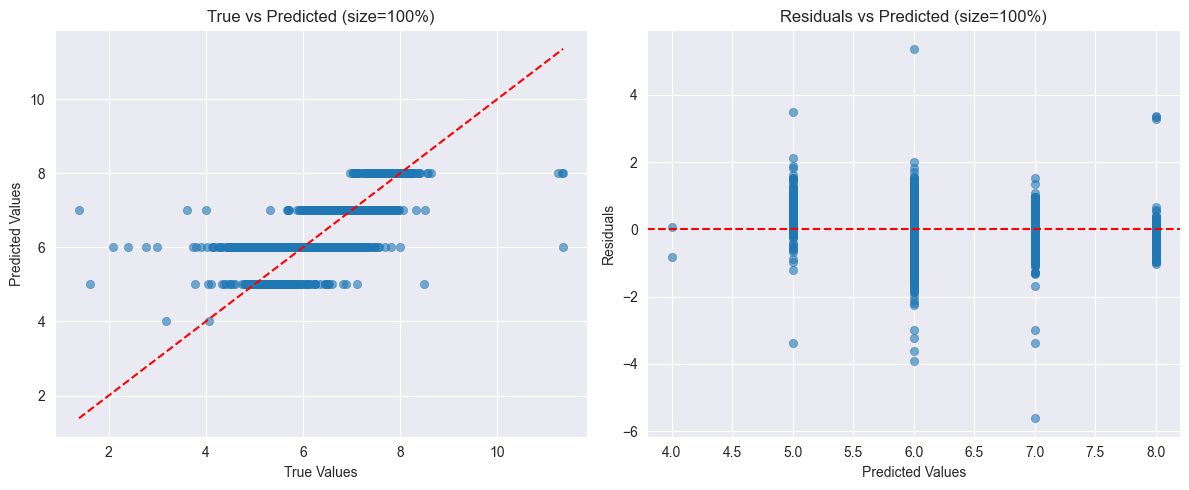

In [9]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, DoubleType
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

# UDF για μετατροπή Vector σε λίστα
vector_to_array_udf = udf(lambda v: v.toArray().tolist(), ArrayType(DoubleType()))

monitor = ResourceMonitorListener()

# Repartition και cache
train_data = train_data.repartition(20).cache()
train_count = train_data.count()

sizes = [0.1, 0.25, 0.5, 1]

for size in sizes:
    print(f"\nKNN Training with {size * 100}% of data")

    # Υποσύνολο δεδομένων
    train_subset = train_data if size == 1 else train_data.sample(fraction=size, seed=42)

    # Μετατροπή σε pandas
    train_pd = train_subset.select(
        vector_to_array_udf("scaled_features").alias("features"), "trip_duration"
    ).dropna().toPandas()

    test_pd = test_data.select(
        vector_to_array_udf("scaled_features").alias("features"), "trip_duration"
    ).dropna().toPandas()

    X_train = np.vstack(train_pd["features"].values)
    y_train = train_pd["trip_duration"].values
    X_test = np.vstack(test_pd["features"].values)
    y_test = test_pd["trip_duration"].values

    # Εκπαίδευση
    print("Training K-Nearest Neighbors Regressor (KNN)...")
    monitor.start_monitoring()
    start_train = time.time()

    knn_model = KNeighborsRegressor(
        n_neighbors=11,
        weights='distance',
        algorithm='auto',
        leaf_size=10,
        p=2,
        n_jobs=-1
    )
    knn_model.fit(X_train, y_train)

    training_time = time.time() - start_train
    train_metrics = monitor.stop_monitoring()

    # Inference
    time.sleep(3)
    monitor.start_monitoring()
    start_infer = time.time()

    y_pred = knn_model.predict(X_test)

    inference_latency = time.time() - start_infer
    infer_metrics = monitor.stop_monitoring()

    # Καθαρισμός αρνητικών προβλέψεων
    y_pred = np.where(y_pred < 0, 0, np.round(y_pred))

    # Μετρικές
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Εκτύπωση αποτελεσμάτων
    print(f"\nKNN Results for {size * 100}% data:")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R-Squared: {r2:.4f}")
    print(f"Training Time: {training_time:.2f} sec | Inference Latency: {inference_latency:.2f} sec")
    print(f"*Training* CPU: {train_metrics['cpu_usage']:.2f}% | Memory: {train_metrics['mem_usage']:.2f}%")
    print(f"*Training* Disk Read: {train_metrics['disk_read_mb']:.2f} MB | Write: {train_metrics['disk_write_mb']:.2f} MB")
    print(f"*Inference* CPU: {infer_metrics['cpu_usage']:.2f}% | Memory: {infer_metrics['mem_usage']:.2f}%")
    print(f"*Inference* Disk Read: {infer_metrics['disk_read_mb']:.2f} MB | Write: {infer_metrics['disk_write_mb']:.2f} MB")

    # ========== Διαγράμματα ==========
    if size == 1:
        plt.figure(figsize=(12, 5))

        # Scatter Plot: True vs Predicted
        plt.subplot(1, 2, 1)
        sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, edgecolor=None)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        plt.title(f"True vs Predicted (size={int(size*100)}%)")

        # Residual Plot
        residuals = y_test - y_pred
        plt.subplot(1, 2, 2)
        sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, edgecolor=None)
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel("Predicted Values")
        plt.ylabel("Residuals")
        plt.title(f"Residuals vs Predicted (size={int(size*100)}%)")

        plt.tight_layout()
        plt.show()

In [10]:
train_data = train_data.repartition(20).cache()
train_count = train_data.count()

# Κλάση υπεύθυνη για την παρακολούθηση των τιμών των υπολογιστικών πόρων(CPU, memory, Disk I/O)
monitor = ResourceMonitorListener()

# Διαφορετικά μεγέθη δεδομένων για scaling test
sizes = [0.1, 0.25, 0.5, 1]

for size in sizes:
    print(f"Training with {size * 100}% of data")

    # Επιλογή τυχαίου δείγματος δεδομένων
    if size == 1:
        train_subset = train_data  # Χρησιμοποιούμε όλο το train_data για 100%
    else:
        # Επιλογή τυχαίου τμήματος δεδομένων για τα άλλα ποσοστά
        train_subset = train_data.sample(fraction=size, seed=42)

    # Μοντέλα 
    models = {
        "XGBoost Regressor": SparkXGBRegressor(
            features_col="scaled_features",
            label_col="trip_duration",
            num_workers=2,
            max_depth=10
        )
    }

    # Αξιολόγηση(δημοφιλείς μετρικές)
    evaluator_rmse = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="rmse")
    evaluator_r2 = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="r2")
    evaluator_mae = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="mae")

    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Υπολογισμοί των πόρων που χρησιμοποιήθηκαν κατά το training και το inference
        monitor.start_monitoring()
        start_train = time.time()

        trained_model = model.fit(train_subset)
        training_time = time.time() - start_train

        train_metrics = monitor.stop_monitoring()

        # Καθυστέρηση για σταθεροποίηση των μετρήσεων
        time.sleep(3)

        start_infer = time.time()
        monitor.start_monitoring()

        predictions = trained_model.transform(test_data)
        inference_latency = time.time() - start_infer

        infer_metrics = monitor.stop_monitoring()

        # Δε θέλουμε predictions<0 (γιατί δεν υπάρχουν διαδρομές που διαρκούν<0 sec)
        # Θέλουμε ακέραιους αριθμούς ως prediction.
        predictions = predictions.withColumn(
            "prediction",
            when(col("prediction") < 0, 0).otherwise(round(col("prediction"), 0))
        )

        # Υπολογισμός μετρικών
        rmse = evaluator_rmse.evaluate(predictions)
        r2 = evaluator_r2.evaluate(predictions)
        mae = evaluator_mae.evaluate(predictions)

        # Εκτύπωση αποτελεσμάτων
        print(f"\n{name} (Data Size: {size * 100}%)")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"R-Squared: {r2:.4f}")
        print(f"Training Time: {training_time:.2f} sec - Inference Latency: {inference_latency:.2f} sec")
        print(f"*Training* CPU: {train_metrics['cpu_usage']:.2f}% | Memory: {train_metrics['mem_usage']:.2f}%")
        print(f"*Training* Disk Read: {train_metrics['disk_read_mb']:.2f} MB | Write: {train_metrics['disk_write_mb']:.2f} MB")
        print(f"*Inference* CPU: {infer_metrics['cpu_usage']:.2f}% | Memory: {infer_metrics['mem_usage']:.2f}%")
        print(f"*Inference* Disk Read: {infer_metrics['disk_read_mb']:.2f} MB | Write: {infer_metrics['disk_write_mb']:.2f} MB")

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/home/dgour/.local/lib/python3.8/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/dgour/.local/lib/python3.8/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.8/socket.py", line 669, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

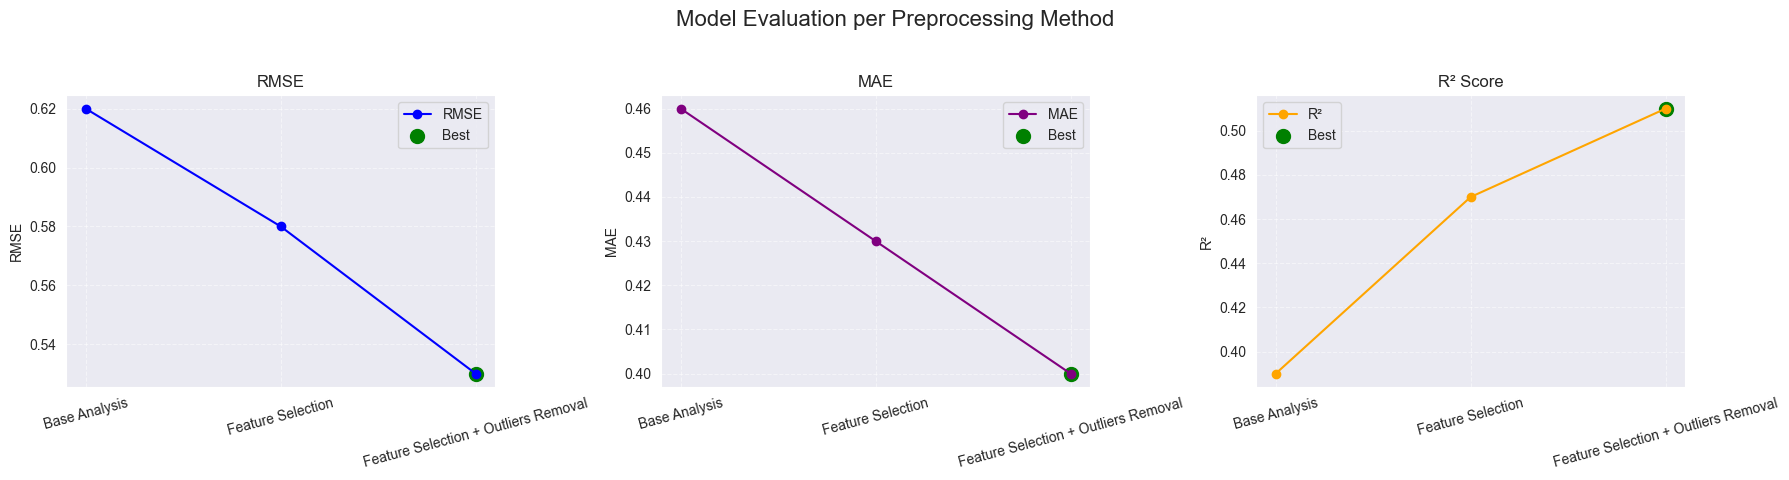

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Ετικέτες
methods = ['Base Analysis', 'Feature Selection', 'Feature Selection + Outliers Removal']
x = np.arange(len(methods))

# Μετρικές
rmse = [0.62, 0.58, 0.53]
mae = [0.46, 0.43, 0.40]
r2 = [0.39, 0.47, 0.51]

# Δημιουργία figure με 3 υποδιαγράμματα σε 1 γραμμή
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Model Evaluation per Preprocessing Method", fontsize=16)

# --------- 1. RMSE ---------
best_rmse_idx = np.argmin(rmse)
axs[0].plot(x, rmse, marker='o', linestyle='-', color='blue', label="RMSE")
axs[0].scatter(best_rmse_idx, rmse[best_rmse_idx], color='green', s=100, label="Best")
axs[0].set_title("RMSE")
axs[0].set_xticks(x)
axs[0].set_xticklabels(methods, rotation=15)
axs[0].set_ylabel("RMSE")
axs[0].grid(True, linestyle='--', alpha=0.5)
axs[0].legend()

# --------- 2. MAE ---------
best_time_idx = np.argmin(mae)
axs[1].plot(x, mae, marker='o', linestyle='-', color='purple', label="MAE")
axs[1].scatter(best_time_idx, mae[best_time_idx], color='green', s=100, label="Best")
axs[1].set_title("MAE")
axs[1].set_xticks(x)
axs[1].set_xticklabels(methods, rotation=15)
axs[1].set_ylabel("MAE")
axs[1].grid(True, linestyle='--', alpha=0.5)
axs[1].legend()

# --------- 3. R² ---------
best_r2_idx = np.argmax(r2)
axs[2].plot(x, r2, marker='o', linestyle='-', color='orange', label="R²")
axs[2].scatter(best_r2_idx, r2[best_r2_idx], color='green', s=100, label="Best")
axs[2].set_title("R² Score")
axs[2].set_xticks(x)
axs[2].set_xticklabels(methods, rotation=15)
axs[2].set_ylabel("R²")
axs[2].grid(True, linestyle='--', alpha=0.5)
axs[2].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [8]:
# Ανάλυση χωρίς partitioning και caching

train_count = train_data.count()

# Κλάση υπεύθυνη για την παρακολούθηση των τιμών των υπολογιστικών πόρων(CPU, memory, Disk I/O)
monitor = ResourceMonitorListener()

# Διαφορετικά μεγέθη δεδομένων για scaling test
sizes = [0.1, 0.25, 0.5, 1]

for size in sizes:
    print(f"Training with {size * 100}% of data")

    # Επιλογή τυχαίου δείγματος δεδομένων
    if size == 1:
        train_subset = train_data  # Χρησιμοποιούμε όλο το train_data για 100%
    else:
        # Επιλογή τυχαίου τμήματος δεδομένων για τα άλλα ποσοστά
        train_subset = train_data.sample(fraction=size, seed=42)

    # Μοντέλα 
    models = {
        "XGBoost Regressor": SparkXGBRegressor(
            features_col="scaled_features",
            label_col="trip_duration",
            num_workers=2,
            max_depth=10
        )
    }

    # Αξιολόγηση(δημοφιλείς μετρικές)
    evaluator_rmse = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="rmse")
    evaluator_r2 = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="r2")
    evaluator_mae = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="mae")

    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Υπολογισμοί των πόρων που χρησιμοποιήθηκαν κατά το training και το inference
        monitor.start_monitoring()
        start_train = time.time()

        trained_model = model.fit(train_subset)
        training_time = time.time() - start_train

        train_metrics = monitor.stop_monitoring()

        # Καθυστέρηση για σταθεροποίηση των μετρήσεων
        time.sleep(3)

        start_infer = time.time()
        monitor.start_monitoring()

        predictions = trained_model.transform(test_data)
        inference_latency = time.time() - start_infer

        infer_metrics = monitor.stop_monitoring()

        # Δε θέλουμε predictions<0 (γιατί δεν υπάρχουν διαδρομές που διαρκούν<0 sec)
        # Θέλουμε ακέραιους αριθμούς ως prediction.
        predictions = predictions.withColumn(
            "prediction",
            when(col("prediction") < 0, 0).otherwise(round(col("prediction"), 0))
        )

        # Υπολογισμός μετρικών
        rmse = evaluator_rmse.evaluate(predictions)
        r2 = evaluator_r2.evaluate(predictions)
        mae = evaluator_mae.evaluate(predictions)

        # Εκτύπωση αποτελεσμάτων
        print(f"\n{name} (Data Size: {size * 100}%)")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"R-Squared: {r2:.4f}")
        print(f"Training Time: {training_time:.2f} sec - Inference Latency: {inference_latency:.2f} sec")
        print(f"*Training* CPU: {train_metrics['cpu_usage']:.2f}% | Memory: {train_metrics['mem_usage']:.2f}%")
        print(f"*Training* Disk Read: {train_metrics['disk_read_mb']:.2f} MB | Write: {train_metrics['disk_write_mb']:.2f} MB")
        print(f"*Inference* CPU: {infer_metrics['cpu_usage']:.2f}% | Memory: {infer_metrics['mem_usage']:.2f}%")
        print(f"*Inference* Disk Read: {infer_metrics['disk_read_mb']:.2f} MB | Write: {infer_metrics['disk_write_mb']:.2f} MB")

Training with 10.0% of data

Training XGBoost Regressor...


2025-04-18 18:09:05,432 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 2 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'max_depth': 10, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
/usr/local/lib/python3.8/dist-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/xgboost/core.py:265: FutureWarning: Your system has an 


XGBoost Regressor (Data Size: 10.0%)
RMSE: 0.5716
MAE: 0.4149
R-Squared: 0.4883
Training Time: 17.97 sec - Inference Latency: 0.25 sec
*Training* CPU: 73.39% | Memory: 75.28%
*Training* Disk Read: 6.80 MB | Write: 4.27 MB
*Inference* CPU: 19.40% | Memory: 78.80%
*Inference* Disk Read: 0.03 MB | Write: 0.00 MB
Training with 25.0% of data

Training XGBoost Regressor...


2025-04-18 18:09:47,254 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 2 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'max_depth': 10, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-04-18 18:09:51,409 INFO XGBoost-PySpark: _train_booster Training on CPUs 8]
[18:09:52] Task 1 got rank 1[18:09:52] Task 0 got rank 0            (0 + 2) / 2]

2025-04-18 18:09:58,845 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2025-04-18 18:10:06,692 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-18 18:10:09,532 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-18 18:10:12,460 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs



XGBoost Regressor (Data Size: 25.0%)
RMSE: 0.5421
MAE: 0.3974
R-Squared: 0.5397
Training Time: 12.16 sec - Inference Latency: 0.17 sec
*Training* CPU: 65.45% | Memory: 84.95%
*Training* Disk Read: 0.66 MB | Write: 1.89 MB
*Inference* CPU: 16.20% | Memory: 85.20%
*Inference* Disk Read: 1.79 MB | Write: 0.00 MB
Training with 50.0% of data

Training XGBoost Regressor...


2025-04-18 18:10:13,363 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 2 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'max_depth': 10, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-04-18 18:10:16,469 INFO XGBoost-PySpark: _train_booster Training on CPUs 8]
[18:10:17] Task 0 got rank 0[18:10:17] Task 1 got rank 1            (0 + 2) / 2]

2025-04-18 18:10:23,237 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2025-04-18 18:10:30,484 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-18 18:10:33,546 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-18 18:10:36,754 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs



XGBoost Regressor (Data Size: 50.0%)
RMSE: 0.5241
MAE: 0.3870
R-Squared: 0.5698
Training Time: 10.41 sec - Inference Latency: 0.14 sec
*Training* CPU: 41.75% | Memory: 86.04%
*Training* Disk Read: 0.00 MB | Write: 3.38 MB
*Inference* CPU: 3.30% | Memory: 86.50%
*Inference* Disk Read: 0.00 MB | Write: 0.00 MB
Training with 100% of data

Training XGBoost Regressor...


2025-04-18 18:10:37,450 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 2 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'max_depth': 10, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-04-18 18:10:40,910 INFO XGBoost-PySpark: _train_booster Training on CPUs 8]
[18:10:41] Task 0 got rank 0[18:10:41] Task 1 got rank 1            (0 + 2) / 2]

2025-04-18 18:10:49,462 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2025-04-18 18:10:56,864 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-18 18:11:00,174 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-18 18:11:04,420 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs



XGBoost Regressor (Data Size: 100%)
RMSE: 0.5034
MAE: 0.3750
R-Squared: 0.6030
Training Time: 12.62 sec - Inference Latency: 0.16 sec
*Training* CPU: 65.30% | Memory: 86.82%
*Training* Disk Read: 19.07 MB | Write: 5.54 MB
*Inference* CPU: 37.30% | Memory: 87.20%
*Inference* Disk Read: 0.00 MB | Write: 0.00 MB


In [9]:
# Ανάλυση χωρίς partitioning(μόνο caching)

train_data = train_data.cache()
train_count = train_data.count()

# Κλάση υπεύθυνη για την παρακολούθηση των τιμών των υπολογιστικών πόρων(CPU, memory, Disk I/O)
monitor = ResourceMonitorListener()

# Διαφορετικά μεγέθη δεδομένων για scaling test
sizes = [1]

for size in sizes:
    print(f"Training with {size * 100}% of data")

    # Επιλογή τυχαίου δείγματος δεδομένων
    if size == 1:
        train_subset = train_data  # Χρησιμοποιούμε όλο το train_data για 100%
    else:
        # Επιλογή τυχαίου τμήματος δεδομένων για τα άλλα ποσοστά
        train_subset = train_data.sample(fraction=size, seed=42)

    # Μοντέλα 
    models = {
        "XGBoost Regressor": SparkXGBRegressor(
            features_col="scaled_features",
            label_col="trip_duration",
            num_workers=2,
            max_depth=10
        )
    }

    # Αξιολόγηση(δημοφιλείς μετρικές)
    evaluator_rmse = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="rmse")
    evaluator_r2 = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="r2")
    evaluator_mae = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="mae")

    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Υπολογισμοί των πόρων που χρησιμοποιήθηκαν κατά το training και το inference
        monitor.start_monitoring()
        start_train = time.time()

        trained_model = model.fit(train_subset)
        training_time = time.time() - start_train

        train_metrics = monitor.stop_monitoring()

        # Καθυστέρηση για σταθεροποίηση των μετρήσεων
        time.sleep(3)

        start_infer = time.time()
        monitor.start_monitoring()

        predictions = trained_model.transform(test_data)
        inference_latency = time.time() - start_infer

        infer_metrics = monitor.stop_monitoring()

        # Δε θέλουμε predictions<0 (γιατί δεν υπάρχουν διαδρομές που διαρκούν<0 sec)
        # Θέλουμε ακέραιους αριθμούς ως prediction.
        predictions = predictions.withColumn(
            "prediction",
            when(col("prediction") < 0, 0).otherwise(round(col("prediction"), 0))
        )

        # Υπολογισμός μετρικών
        rmse = evaluator_rmse.evaluate(predictions)
        r2 = evaluator_r2.evaluate(predictions)
        mae = evaluator_mae.evaluate(predictions)

        # Εκτύπωση αποτελεσμάτων
        print(f"\n{name} (Data Size: {size * 100}%)")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE {mae:.4f}")
        print(f"R-Squared: {r2:.4f}")
        print(f"Training Time: {training_time:.2f} sec - Inference Latency: {inference_latency:.2f} sec")
        print(f"*Training* CPU: {train_metrics['cpu_usage']:.2f}% | Memory: {train_metrics['mem_usage']:.2f}%")
        print(f"*Training* Disk Read: {train_metrics['disk_read_mb']:.2f} MB | Write: {train_metrics['disk_write_mb']:.2f} MB")
        print(f"*Inference* CPU: {infer_metrics['cpu_usage']:.2f}% | Memory: {infer_metrics['mem_usage']:.2f}%")
        print(f"*Inference* Disk Read: {infer_metrics['disk_read_mb']:.2f} MB | Write: {infer_metrics['disk_write_mb']:.2f} MB")

Training with 100% of data

Training XGBoost Regressor...


2025-04-18 18:11:24,676 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 2 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'max_depth': 10, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-04-18 18:11:25,172 INFO XGBoost-PySpark: _train_booster Training on CPUs
[18:11:26] Task 0 got rank 0[18:11:26] Task 1 got rank 1            (0 + 2) / 2]

2025-04-18 18:11:34,192 INFO XGBoost-PySpark: _fit Finished xgboost training!   
2025-04-18 18:11:41,440 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-18 18:11:44,472 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs
2025-04-18 18:11:47,047 INFO XGBoost-PySpark: predict_udf Do the inference on the CPUs



XGBoost Regressor (Data Size: 100%)
RMSE: 0.5034
MAE 0.3750
R-Squared: 0.6030
Training Time: 10.00 sec - Inference Latency: 0.14 sec
*Training* CPU: 48.59% | Memory: 88.02%
*Training* Disk Read: 11.81 MB | Write: 23.48 MB
*Inference* CPU: 3.60% | Memory: 88.30%
*Inference* Disk Read: 0.00 MB | Write: 0.00 MB


In [10]:
# Ανάλυση χωρίς caching(μόνο partitioning)

train_data = train_data.repartition(20)
train_count = train_data.count()

# Κλάση υπεύθυνη για την παρακολούθηση των τιμών των υπολογιστικών πόρων(CPU, memory, Disk I/O)
monitor = ResourceMonitorListener()

# Διαφορετικά μεγέθη δεδομένων για scaling test
sizes = [1]

for size in sizes:
    print(f"Training with {size * 100}% of data")

    # Επιλογή τυχαίου δείγματος δεδομένων
    if size == 1:
        train_subset = train_data  # Χρησιμοποιούμε όλο το train_data για 100%
    else:
        # Επιλογή τυχαίου τμήματος δεδομένων για τα άλλα ποσοστά
        train_subset = train_data.sample(fraction=size, seed=42)

    # Μοντέλα 
    models = {
        "XGBoost Regressor": SparkXGBRegressor(
            features_col="scaled_features",
            label_col="trip_duration",
            num_workers=2,
            max_depth=10
        )
    }

    # Αξιολόγηση(δημοφιλείς μετρικές)
    evaluator_rmse = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="rmse")
    evaluator_r2 = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="r2")
    evaluator_mae = RegressionEvaluator(labelCol="trip_duration", predictionCol="prediction", metricName="mae")

    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Υπολογισμοί των πόρων που χρησιμοποιήθηκαν κατά το training και το inference
        monitor.start_monitoring()
        start_train = time.time()

        trained_model = model.fit(train_subset)
        training_time = time.time() - start_train

        train_metrics = monitor.stop_monitoring()

        # Καθυστέρηση για σταθεροποίηση των μετρήσεων
        time.sleep(3)

        start_infer = time.time()
        monitor.start_monitoring()

        predictions = trained_model.transform(test_data)
        inference_latency = time.time() - start_infer

        infer_metrics = monitor.stop_monitoring()

        # Δε θέλουμε predictions<0 (γιατί δεν υπάρχουν διαδρομές που διαρκούν<0 sec)
        # Θέλουμε ακέραιους αριθμούς ως prediction.
        predictions = predictions.withColumn(
            "prediction",
            when(col("prediction") < 0, 0).otherwise(round(col("prediction"), 0))
        )

        # Υπολογισμός μετρικών
        rmse = evaluator_rmse.evaluate(predictions)
        r2 = evaluator_r2.evaluate(predictions)
        mae = evaluator_mae.evaluate(predictions)

        # Εκτύπωση αποτελεσμάτων
        print(f"\n{name} (Data Size: {size * 100}%)")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE {mae:.4f}")
        print(f"R-Squared: {r2:.4f}")
        print(f"Training Time: {training_time:.2f} sec - Inference Latency: {inference_latency:.2f} sec")
        print(f"*Training* CPU: {train_metrics['cpu_usage']:.2f}% | Memory: {train_metrics['mem_usage']:.2f}%")
        print(f"*Training* Disk Read: {train_metrics['disk_read_mb']:.2f} MB | Write: {train_metrics['disk_write_mb']:.2f} MB")
        print(f"*Inference* CPU: {infer_metrics['cpu_usage']:.2f}% | Memory: {infer_metrics['mem_usage']:.2f}%")
        print(f"*Inference* Disk Read: {infer_metrics['disk_read_mb']:.2f} MB | Write: {infer_metrics['disk_write_mb']:.2f} MB")

Training with 100% of data

Training XGBoost Regressor...


2025-04-18 18:13:31,355 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 2 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'max_depth': 10, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
/usr/local/lib/python3.8/dist-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/xgboost/core.py:265: FutureWarning: Your system has an 


XGBoost Regressor (Data Size: 100%)
RMSE: 0.5015
MAE 0.3749
R-Squared: 0.6061
Training Time: 14.58 sec - Inference Latency: 0.13 sec
*Training* CPU: 61.01% | Memory: 79.93%
*Training* Disk Read: 100.19 MB | Write: 20.75 MB
*Inference* CPU: 3.40% | Memory: 81.10%
*Inference* Disk Read: 0.00 MB | Write: 0.00 MB
